In [1]:
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data.dataset import random_split

import torch.nn as nn
import time
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML
from tabulate import tabulate
from IPython.display import clear_output



import sys
sys.path.append("/Users/charlottebeylier/Documents/PhD/Spatial and Conceptual Learning/github_code/Mono_Multi_TASK/Models")
from Networks_v2 import Net_Individual

sys.path.append("/Users/charlottebeylier/Documents/PhD/Spatial and Conceptual Learning/github_code/Mono_Multi_TASK/Experimental_setup")
from Experiment_v5 import Experiment
sys.path.append("/Users/charlottebeylier/Documents/PhD/Spatial and Conceptual Learning/github_code/Mono_Multi_TASK/Training")
from Training_Networks_frozen_weights import Training_frozen_weights
sys.path.append("/Users/charlottebeylier/Documents/PhD/Spatial and Conceptual Learning/github_code/Mono_Multi_TASK/Analysis")
from Check import Checkup



sys.path.append("/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis")
from Manifold_Analysis import Manifold_analysis



from sklearn.preprocessing import scale
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.metrics import pairwise_distances

from matplotlib.ticker import NullFormatter
from collections import OrderedDict
from functools import partial
from sklearn import manifold, datasets

In [2]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)

    print(f'Random seed {seed} has been set.')

SEED = 2021
set_seed(seed=SEED)
# if gpu is to be used
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print("Device: ", device)

G_SEED = torch.Generator()
G_SEED.manual_seed(SEED)

Device:  cpu
Random seed 2021 has been set.


# Generate the Dataset

In [3]:
WIDTH = 50
BATCH_SIZE = 32
Nodes_Second = 10
Nodes_Third = 10
EPOCH = 5
ITERATION = 3

In [4]:
set_seed(seed=SEED)
experiment = Experiment(width = WIDTH,batch_size=BATCH_SIZE,size_output_multi=2)
dataset_train,dataset_space_train,dataset_weather_train,dataset_val,dataset_space_val,dataset_weather_val,dataset_test,dataset_space_test,dataset_weather_test= experiment.Generate_data()

Random seed 2021 has been set.
Test size dataset space torch.Size([249, 6])
Test size dataset weather torch.Size([249, 6])
Train size dataset space torch.Size([1750, 6])
Train size dataset weather torch.Size([1750, 6])


In [5]:
train_loader_weather = torch.utils.data.DataLoader(dataset_weather_train,batch_size=10,shuffle = False )
val_loader_weather = torch.utils.data.DataLoader(dataset_weather_val,batch_size=1,shuffle = False )
test_loader_weather = torch.utils.data.DataLoader(dataset_weather_test,batch_size=1,shuffle = False ) #bATCH SIZE =1 HERE FOR THE DATASET ONLY, ELSE TAKE WHATEVER BATCH SIZE IN INDIVIDUAL MODE

In [6]:
train_loader_space = torch.utils.data.DataLoader(dataset_space_train,batch_size=BATCH_SIZE,shuffle = False )
val_loader_space = torch.utils.data.DataLoader(dataset_space_val,batch_size=BATCH_SIZE,shuffle = False )
test_loader_space = torch.utils.data.DataLoader(dataset_space_test,batch_size=1,shuffle = False ) #bATCH SIZE =1 HERE FOR THE DATASET ONLY, ELSE TAKE WHATEVER BATCH SIZE IN INDIVIDUAL MODE

## Analysis setup

In [7]:
do_analysis = True
type_an = 0
frequence = 10

In [8]:
ITERATION =  4
EPOCH = 51
frequence = 1
Multi_losses = []
representation_analysis = True
type_analyse = 0

# Individual Networks

In [9]:
network_type = "Individual"
option_interleaved = False

In [35]:
weather_losses = []

List_cka_init_weather = [[] for iteration in range(ITERATION)]

for iteration in range(ITERATION):
    print("Iteration",iteration)
    
    Input_Dimension = 3
    model_weather = Net_Individual(Input_Dimension ,Nodes_Second,Nodes_Third,1)  
    optimizer_weather = torch.optim.Adam(model_weather.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    criterion = nn.BCEWithLogitsLoss()
    spatial_task = False
    
    training = Training_frozen_weights()
    model_weather,val_losses = training.training_individual(model_weather,optimizer_weather,criterion,EPOCH,train_loader_weather,val_loader_weather,test_loader_weather,spatial_task,option_interleaved,do_analysis,type_an,network_type,frequence)
    weather_losses.append(val_losses)
    List_cka_init_weather[iteration].append(training.Liste_cka_init)


Iteration 0
Iteration 1
Iteration 2


In [37]:
a = torch.tensor(List_cka_init_weather).squeeze(1)
print(a.shape)
#print(a)

torch.Size([3, 3, 50])


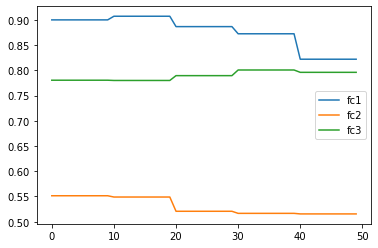

In [38]:
epoch = [i for i in range(len(a[0][0]))]
plt.figure()
for i in range(len(Names_hook)):
    plt.plot(epoch,a[0][i],label = Names_hook[i])

plt.legend()

In [51]:
spatial_losses = []
List_cka_init_space = [[] for iteration in range(ITERATION)]

for iteration in range(ITERATION):
    print("Iteration",iteration)
    Input_Dimension = 2
    model_space = Net_Individual(Input_Dimension ,Nodes_Second,Nodes_Third,1)    
    optimizer_space = torch.optim.Adam(model_space.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    spatial_task = True
    training = Training_frozen_weights()
    model_space,val_losses = training.training_individual(model_space,optimizer_space,criterion,EPOCH,train_loader_space,val_loader_space,test_loader_space,spatial_task,option_interleaved,do_analysis,type_an,network_type,frequence)
    spatial_losses.append(val_losses)
    List_cka_init_space[iteration].append(training.Liste_cka_init)

Iteration 2
Iteration 2
Iteration 2


torch.Size([3, 3, 50])


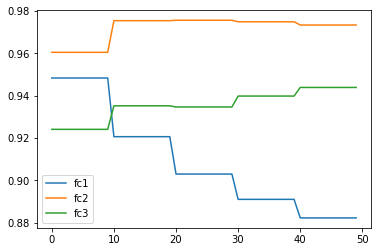

In [55]:
b = torch.tensor(List_cka_init_space).squeeze(1)
print(b.shape)

epoch = [i for i in range(len(b[0][0]))]
plt.figure()
for i in range(len(Names_hook)):
    plt.plot(epoch,b[0][i],label = Names_hook[i])

plt.legend()

In [56]:
model_individual_weather = model_weather
model_individual_space = model_space

In [57]:
spatial_losses_option_0 = torch.tensor(spatial_losses)
weather_losses_option_0 = torch.tensor(weather_losses)

# Frozen weights

# Interleaved Training

In [10]:
option_interleaved = True

## Train the Network

In [18]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import torch.nn as nn
import sys
sys.path.append("/Users/charlottebeylier/Documents/PhD/Spatial and Conceptual Learning/github_code/Mono_Multi_TASK/Analysis")
from Generate_data_activity_spatial_conceptual import Generate_Data
from Representation_learning import Representation_Learning
from Similarity_of_Neural_Network_Representations_Revisited import feature_space_linear_cka

sys.path.append("/Users/charlottebeylier/Documents/PhD/Spatial and Conceptual Learning/github_code/Mono_Multi_TASK/Models")
from Networks_v2 import Net_Multi,Net_Individual
from Mask import Masks


class Training_frozen_weights():
    
    def __init__(self):
        self.Liste_cka =[[] for i in range(3)] # 3 corresponds to the number of hidden layers
        self.Liste_cka_init =[[] for i in range(3)]
        
        self.Liste_cka_weather =[[] for i in range(3)] # 3 corresponds to the number of hidden layers
        self.Liste_cka_init_weather =[[] for i in range(3)]
        
        self.Liste_cka_space =[[] for i in range(3)] # 3 corresponds to the number of hidden layers
        self.Liste_cka_init_space =[[] for i in range(3)]
        

    
    def training_individual(self,model,optimizer,criterion,Epoch,train_loader,val_loader,test_loader,spatial_task,option_interleaved,epoch_interleaved,do_analysis,type,network_type,frequence):
        
        


        losses = []
        val_losses = []

        for epoch in range(Epoch):

            loss = 0
            val_loss = 0 

            for x_batch, y_batch in train_loader:
                if spatial_task:
                    x_batch = x_batch[:,0:2]
                else:
                    x_batch = x_batch[:,2:5]

                optimizer.zero_grad()
                output = model(x_batch).squeeze(1)

                output_loss = criterion(output,y_batch)
                output_loss.backward()
                optimizer.step()

                loss += output_loss.detach().numpy()
            losses.append(loss/len(train_loader))

            with torch.no_grad():
                for x_val, y_val in val_loader:
                    model.eval() 
                    if spatial_task:
                        x_val = x_val[:,0:2]
                    else:
                        x_val = x_val[:,2:5]
                    yhat = model(x_val).squeeze(1)
                    val_loss += criterion(yhat,y_val)
                val_losses.append(val_loss.item()/len(val_loader))


    

            if do_analysis:
                
                if np.mod(epoch,frequence)==0: 
                    generate_data = Generate_Data(model,test_loader)
                    activity_layer = generate_data.generate_preprocessed_data(multi = False)

                    if type == 0:
                        if epoch == 0:
                            self.activity_layer_init = activity_layer
                            self.activity_layer_t_prime = activity_layer
                        else:
                            self.activity_layer_t = self.activity_layer_t_prime
                            self.activity_layer_t_prime = activity_layer

                            for layer in range(3):

                                cka = feature_space_linear_cka(self.activity_layer_t[layer], self.activity_layer_t_prime[layer], debiased=False)
                                cka_init =feature_space_linear_cka(self.activity_layer_init[layer], self.activity_layer_t_prime[layer], debiased=False)    
                                
                                for g in range(frequence):
                                    self.Liste_cka[layer].append(cka)
                                    self.Liste_cka_init[layer].append(cka_init)

                    if type == 1:
                        representation_learning = Representation_Learning(frequence, network_type)
                        representation_learning.Isomap_plot_save(activity_layer,epoch,network_type)

                    

       
        return model,val_losses
    

    
    
    
    
    
    
    
    def training_individual_interleaved(self,Epoch,Nodes_Second,Nodes_Third,train_loader_weather,val_loader_weather,test_loader_weather,train_loader_space,val_loader_space,test_loader_space,do_analysis,type,network_type,frequence):
        
        
        Input_Dimension = 3
        model_weather = Net_Individual(input_dimension=3,nodes_second = Nodes_Second,nodes_third = Nodes_Third,nodes_output = 1)  
        optimizer_weather = torch.optim.Adam(model_weather.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        Input_Dimension = 2
        model_space = Net_Individual(Input_Dimension ,Nodes_Second,Nodes_Third,1)    
        optimizer_space = torch.optim.Adam(model_space.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

        criterion = nn.BCEWithLogitsLoss()
        


        losses_weather = []
        val_losses_weather = []
        
        losses_space = []
        val_losses_space = []

        for epoch in range(Epoch):

            loss = 0
            val_loss = 0 

            for x_batch, y_batch in train_loader_weather:
                x_batch = x_batch[:,2:5]

                optimizer_weather.zero_grad()
                output = model_weather(x_batch).squeeze(1)

                output_loss = criterion(output,y_batch)
                output_loss.backward()
                optimizer_weather.step()

                loss += output_loss.detach().numpy()
            losses_weather.append(loss/len(train_loader_weather))

            with torch.no_grad():
                for x_val, y_val in val_loader_weather:
                    model_weather.eval() 
                    x_val = x_val[:,2:5]
                    yhat = model_weather(x_val).squeeze(1)
                    val_loss += criterion(yhat,y_val)
                val_losses_weather.append(val_loss.item()/len(val_loader_weather))
                
            
            
            
            model_space.fc2[0].weight = model_weather.fc2[0].weight
            model_space.fc3[0].weight = model_weather.fc3[0].weight

            for param in model_space.fc2.parameters():
                param.requires_grad = False

            for param in model_space.fc3.parameters():
                param.requires_grad = False
            
            
            loss = 0
            val = 0 

            for x_batch, y_batch in train_loader_space:
                x_batch = x_batch[:,0:2]
                

                optimizer_space.zero_grad()
                output = model_space(x_batch).squeeze(1)

                output_loss = criterion(output,y_batch)
                output_loss.backward()
                optimizer_space.step()

                loss += output_loss.detach().numpy()
            losses_space.append(loss/len(train_loader_space))

            with torch.no_grad():
                for x_val, y_val in val_loader_space:
                    model_space.eval() 
                    x_val = x_val[:,0:2]
                   
                    yhat = model_space(x_val).squeeze(1)
                    val_loss += criterion(yhat,y_val)
                val_losses_space.append(val_loss.item()/len(val_loader_space))


    

            if do_analysis:
                
                if np.mod(epoch,frequence)==0: 
                    generate_data_weather = Generate_Data(model_weather,test_loader_weather)
                    activity_layer_weather = generate_data_weather.generate_preprocessed_data(multi = False)
                    
                    generate_data_space = Generate_Data(model_space,test_loader_space)
                    activity_layer_space = generate_data_space.generate_preprocessed_data(multi = False)

                    if type == 0:
                        if epoch == 0:
                            self.activity_layer_init_weather = activity_layer_weather
                            self.activity_layer_t_prime_weather = activity_layer_weather
                            
                            self.activity_layer_init_space = activity_layer_space
                            self.activity_layer_t_prime_space = activity_layer_space
                        else:
                            self.activity_layer_t_weather = self.activity_layer_t_prime_weather
                            self.activity_layer_t_prime_weather = activity_layer_weather
                            
                            self.activity_layer_t_space = self.activity_layer_t_prime_space
                            self.activity_layer_t_prime_space = activity_layer_space

                            for layer in range(3):

                                cka_weather = feature_space_linear_cka(self.activity_layer_t_weather[layer], self.activity_layer_t_prime_weather[layer], debiased=False)
                                cka_init_weather =feature_space_linear_cka(self.activity_layer_init_weather[layer], self.activity_layer_t_prime_weather[layer], debiased=False)  
                                
                                cka_space = feature_space_linear_cka(self.activity_layer_t_space[layer], self.activity_layer_t_prime_space[layer], debiased=False)
                                cka_init_space =feature_space_linear_cka(self.activity_layer_init_space[layer], self.activity_layer_t_prime_space[layer], debiased=False) 
                                
                                for g in range(frequence):
                                    self.Liste_cka_weather[layer].append(cka_weather)
                                    self.Liste_cka_init_weather[layer].append(cka_init_weather)
                                    
                                    self.Liste_cka_space[layer].append(cka_space)
                                    self.Liste_cka_init_space[layer].append(cka_init_space)

                    if type == 1:
                        representation_learning = Representation_Learning(frequence, network_type)
                        representation_learning.Isomap_plot_save(activity_layer,epoch,network_type)

                    

       
        return model_space,val_losses_space,model_weather,val_losses_weather
    
   

In [19]:
weather_losses = []
spatial_losses = []
List_cka_init_weather_interleaved = [[] for iteration in range(ITERATION)]
List_cka_init_space_interleaved = [[] for iteration in range(ITERATION)]


for iteration in range(ITERATION):
    print("Iteration",iteration)

    training = Training_frozen_weights()
    model_weather,val_losses_weather,model_spatial,val_losses_spatial = training.training_individual_interleaved(EPOCH,Nodes_Second,Nodes_Third,train_loader_weather,val_loader_weather,test_loader_weather,train_loader_space,val_loader_space,test_loader_space,do_analysis,type_an,network_type,frequence)
    weather_losses.append(val_losses_weather)
    spatial_losses.append(val_losses_spatial)
    List_cka_init_weather_interleaved[iteration].append(training.Liste_cka_init_weather)
    List_cka_init_space_interleaved[iteration].append(training.Liste_cka_init_space)
       




Iteration 0
Iteration 1
Iteration 2
Iteration 3


In [122]:
weather_losses_g = []
spatial_losses_g = []
List_cka_init_weather_interleaved = [[] for iteration in range(ITERATION)]
List_cka_init_space_interleaved = [[] for iteration in range(ITERATION)]


for iteration in range(ITERATION):
    print("Iteration",iteration)
    weather_losses = []
    spatial_losses = []
    
    Input_Dimension = 3
    model_weather = Net_Individual(input_dimension=3,nodes_second = Nodes_Second,nodes_third = Nodes_Third,nodes_output = 1)  
    optimizer_weather = torch.optim.Adam(model_weather.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    Input_Dimension = 2
    model_space = Net_Individual(Input_Dimension ,Nodes_Second,Nodes_Third,1)    
    optimizer_space = torch.optim.Adam(model_space.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

    criterion = nn.BCEWithLogitsLoss()
    for epoch in range(np.int(EPOCH/2)):
      
        training = Training_frozen_weights()
        spatial_task = False
        model_weather,val_losses = training.training_individual(model_weather,optimizer_weather,criterion,2,train_loader_weather,val_loader_weather,test_loader_weather,spatial_task,option_interleaved,do_analysis,type_an,network_type,frequence)
        weather_losses.append(val_losses)
        List_cka_init_weather_interleaved[iteration].append(training.Liste_cka_init)
        print(val_losses)

        spatial_task = True
        model_space.fc2[0].weight = model_weather.fc2[0].weight
        model_space.fc3[0].weight = model_weather.fc3[0].weight

        for param in model_space.fc2.parameters():
            param.requires_grad = False

        for param in model_space.fc3.parameters():
            param.requires_grad = False

        model_space,val_losses = training.training_individual(model_space,optimizer_space,criterion,2,train_loader_space,val_loader_space,test_loader_space,spatial_task,option_interleaved,do_analysis,type_an,network_type,frequence)
        spatial_losses.append(val_losses)
        List_cka_init_space_interleaved[iteration].append(training.Liste_cka_init)
        
    weather_losses_tensor = torch.tensor(weather_losses).flatten()
    spatial_losses_tensor = torch.tensor(spatial_losses).flatten()
    
    weather_losses_g.append(weather_losses_tensor.tolist())
    spatial_losses_g.append(spatial_losses_tensor.tolist())
       



Iteration 0
[0.2903491003002098, 0.09032491404928998]
[0.08444142007158849, 0.10961933938678138]
[0.10222919288283598, 0.11632725136552402]
[0.12844792062151647, 0.09297813920076481]
[0.09205674073978035, 0.0648683536506607]
[0.055598750143108486, 0.07212149977445124]
[0.06079328609611802, 0.08376939119939097]
[0.044345920692703766, 0.04397334555585781]
[0.044133448170755575, 0.05488945725924505]
[0.052014425426781294, 0.06792019555468358]
[0.050018054449964384, 0.04812166064917922]
[0.047856011706029246, 0.04766336949411518]
[0.0489658554474672, 0.050827901683493944]
[0.05072204574554382, 0.0525853609990978]
[0.04737158337671436, 0.04991286359951348]
[0.04953453966037544, 0.049903667044782926]
[0.04937265965647115, 0.05082531778033606]
[0.05094031293788749, 0.05018583232749679]
[0.05133987763123904, 0.05200974688023508]
[0.047741505808247355, 0.05031858226340376]
[0.04985969100065365, 0.0514466012408117]
[0.05157007053046523, 0.05266036299283137]
[0.05252661924801752, 0.05184949519400

KeyboardInterrupt: 

In [22]:
c = torch.tensor(List_cka_init_weather_interleaved).squeeze(1)
#c = c.transpose(1,2)
#c = torch.reshape(c,(c.size(0),c.size(1),c.size(2)*c.size(3)))
print(c.shape)

torch.Size([4, 3, 50])


In [25]:
d = torch.tensor(List_cka_init_space_interleaved).squeeze(1)
print(d.shape)

torch.Size([4, 3, 50])


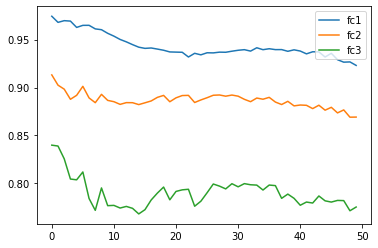

In [28]:
epoch = [i for i in range(len(c[0][0]))]
plt.figure()
for i in range(len(Names_hook)):
    plt.plot(epoch,c[1][i],label = Names_hook[i])

plt.legend()

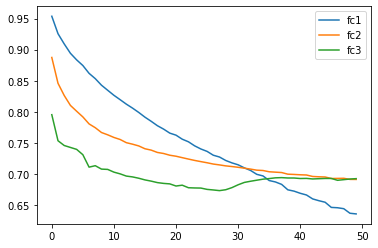

In [29]:
epoch = [i for i in range(len(d[0][0]))]
plt.figure()
for i in range(len(Names_hook)):
    plt.plot(epoch,d[1][i],label = Names_hook[i])

plt.legend()

In [17]:
model_interleaved_weather = model_weather
model_interleaved_space = model_space

In [18]:
spatial_losses_option_2 = torch.tensor(spatial_losses_g)
weather_losses_option_2 = torch.tensor(weather_losses_g)

# Vanilla training

In [10]:
option_interleaved = False

In [11]:
weather_losses = []
spatial_losses = []
List_cka_init_weather_vanilla = [[] for iteration in range(ITERATION)]
List_cka_init_space_vanilla = [[] for iteration in range(ITERATION)]


for iteration in range(ITERATION):
    print("Iteration",iteration)
    Input_Dimension = 3
    model_weather = Net_Individual(Input_Dimension ,Nodes_Second,Nodes_Third,1)  
    optimizer_weather = torch.optim.Adam(model_weather.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    criterion = nn.BCEWithLogitsLoss()
    spatial_task = False
    
    training = Training_frozen_weights()
    model_weather,val_losses = training.training_individual(model_weather,optimizer_weather,criterion,EPOCH,train_loader_weather,val_loader_weather,test_loader_weather,spatial_task,option_interleaved,do_analysis,type_an,network_type,frequence)
    weather_losses.append(val_losses)
    List_cka_init_weather_vanilla[iteration].append(training.Liste_cka_init)
    
    Input_Dimension = 2
    model_space = Net_Individual(Input_Dimension ,Nodes_Second,Nodes_Third,1)    
    optimizer_space = torch.optim.Adam(model_space.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    spatial_task = True
    
    model_space.fc2[0].weight = model_weather.fc2[0].weight
    model_space.fc3[0].weight = model_weather.fc3[0].weight

    for param in model_space.fc2.parameters():
        param.requires_grad = False

    for param in model_space.fc3.parameters():
         param.requires_grad = False
    
    training = Training_frozen_weights()
    model_space,val_losses = training.training_individual(model_space,optimizer_space,criterion,EPOCH,train_loader_space,val_loader_space,test_loader_space,spatial_task,option_interleaved,do_analysis,type_an,network_type,frequence)
    spatial_losses.append(val_losses)   
    List_cka_init_space_vanilla[iteration].append(training.Liste_cka_init)

Iteration 0
Iteration 1
Iteration 2
Iteration 3


In [12]:
e = torch.tensor(List_cka_init_space_vanilla).squeeze(1)
print(e.shape)

torch.Size([4, 3, 50])


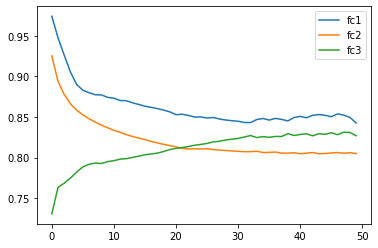

In [15]:
epoch = [i for i in range(len(e[0][0]))]
plt.figure()
for i in range(len(Names_hook)):
    plt.plot(epoch,e[1][i],label = Names_hook[i])

plt.legend()

In [21]:
model_vanilla_weather = model_weather
model_vanilla_space = model_space

In [22]:
spatial_losses_option_1 = torch.tensor(spatial_losses)
weather_losses_option_1 = torch.tensor(weather_losses)

## Train network and visualize representation every N epochs

In [28]:
Liste_cka_g = [List_cka_init_space,List_cka_init_weather,List_cka_init_space_interleaved,List_cka_init_weather_interleaved]

In [19]:
for i in range(len(Liste_cka_g)):
    Mean_Liste_cka_fc1 = torch.tensor(List_cka_init[0][0][0])

    for iteration in range(ITERATION):
        Mean_Liste_cka_fc1 = torch.add(Mean_Liste_cka_fc1,torch.tensor(List_cka_init[iteration][0][0])) 

    Mean_Liste_cka_fc1 = Mean_Liste_cka_fc1/2

In [20]:
Mean_Liste_cka_fc2 = torch.tensor(List_cka_init[0][0][1])

for iteration in range(ITERATION):
    Mean_Liste_cka_fc2 = torch.add(Mean_Liste_cka_fc2,torch.tensor(List_cka_init[iteration][0][1])) 

Mean_Liste_cka_fc2 = Mean_Liste_cka_fc2/2

In [21]:
Mean_Liste_cka_fc3 = torch.tensor(List_cka_init[0][0][2])

for iteration in range(ITERATION):
    Mean_Liste_cka_fc3 = torch.add(Mean_Liste_cka_fc3,torch.tensor(List_cka_init[iteration][0][2])) 
Mean_Liste_cka_fc3 = Mean_Liste_cka_fc3/2

In [14]:
Names_hook = ["fc1","fc2","fc3"]

In [16]:
epochs_cka = [i for i in range(len(Mean_Liste_cka_fc1))]

plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
plt.plot(epochs_cka,Mean_Liste_cka_fc1 ,label = Names_hook[0])
plt.plot(epochs_cka,Mean_Liste_cka_fc2 ,label = Names_hook[1])
plt.plot(epochs_cka,Mean_Liste_cka_fc3 ,label = Names_hook[2])
plt.title("CKA between Initial and current representation 50 Iteration")


plt.legend()

NameError: name 'Mean_Liste_cka_fc1' is not defined

## WEATHER

In [5]:
train_loader = torch.utils.data.DataLoader(dataset_weather_train,batch_size=BATCH_SIZE,shuffle = False )
val_loader = torch.utils.data.DataLoader(dataset_weather_val,batch_size=BATCH_SIZE,shuffle = False )
test_loader_weather = torch.utils.data.DataLoader(dataset_weather_test,batch_size=1,shuffle = False ) #bATCH SIZE =1 HERE FOR THE DATASET ONLY, ELSE TAKE WHATEVER BATCH SIZE IN INDIVIDUAL MODE

In [6]:
Nodes_Second = 20
Nodes_Third = 5
Output_Dimension = 2

Epoch 190, val_loss 0.02475821782672216


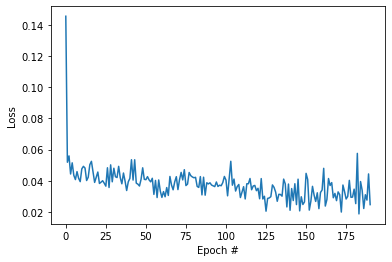

CKA analysis
CKA analysis
CKA analysis
CKA analysis
CKA analysis
CKA analysis
CKA analysis
CKA analysis
CKA analysis
CKA analysis


In [7]:
EPOCH = 200
Weather_losses = []
type_analyse = 0

training = Training()
model,val_losses = training.training_individual(5,Nodes_Second,Nodes_Third,EPOCH,train_loader,val_loader,test_loader_weather,do_analysis,type_analyse,"Weather")
Weather_losses.append(val_losses)

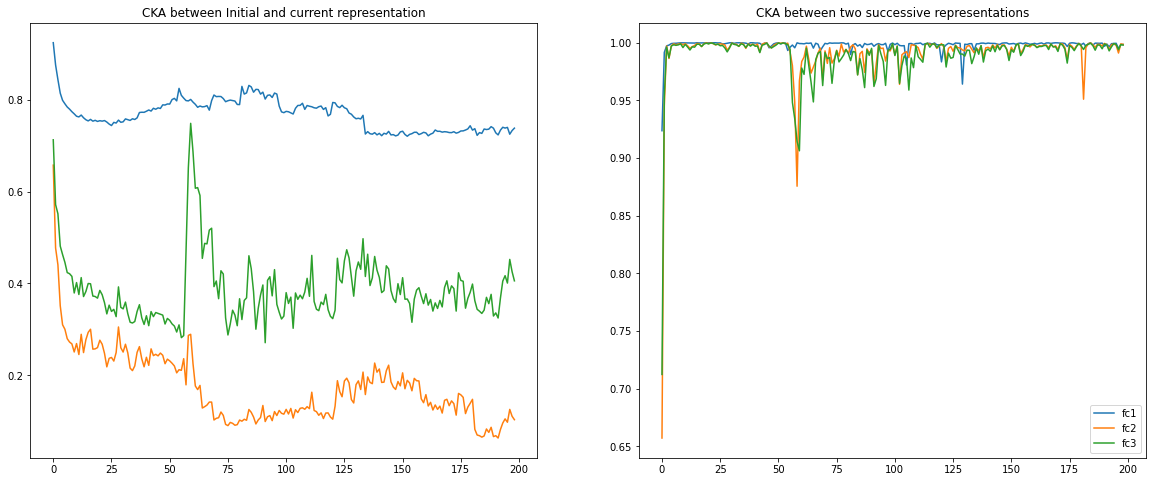

In [9]:
epochs_cka = [i for i in range(len(training.Liste_cka_init[0]))]

plt.figure(figsize = (20,8))
for layer in range(len(Names_hook)):
    plt.subplot(1,2,1)
    plt.plot(epochs_cka,training.Liste_cka_init[layer],label = Names_hook[layer])
    plt.title("CKA between Initial and current representation")
    plt.subplot(1,2,2)
    plt.title("CKA between two successive representations")
    plt.plot(epochs_cka,training.Liste_cka[layer],label = Names_hook[layer])

plt.legend()

In [12]:
## SPATIAL

In [10]:
train_loader = torch.utils.data.DataLoader(dataset_space_train,batch_size=BATCH_SIZE,shuffle = False )
val_loader = torch.utils.data.DataLoader(dataset_space_val,batch_size=BATCH_SIZE,shuffle = False )
test_loader_space = torch.utils.data.DataLoader(dataset_space_test,batch_size=1,shuffle = False ) #bATCH SIZE =1 HERE FOR THE DATASET ONLY, ELSE TAKE WHATEVER BATCH SIZE IN INDIVIDUAL MODE

Epoch 190, val_loss 0.029231733745998807


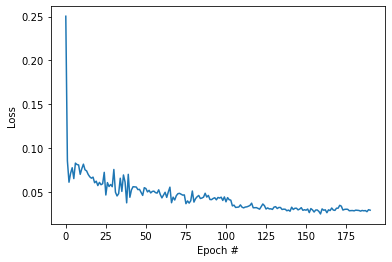

CKA analysis
CKA analysis
CKA analysis
CKA analysis
CKA analysis
CKA analysis
CKA analysis
CKA analysis
CKA analysis
CKA analysis


In [12]:
EPOCH = 200
Spatial_losses = []
training = Training()
model,val_losses = training.training_individual(5,Nodes_Second,Nodes_Third,EPOCH,train_loader,val_loader,test_loader_space,do_analysis,type_analyse,"Spatial")
Spatial_losses.append(val_losses)

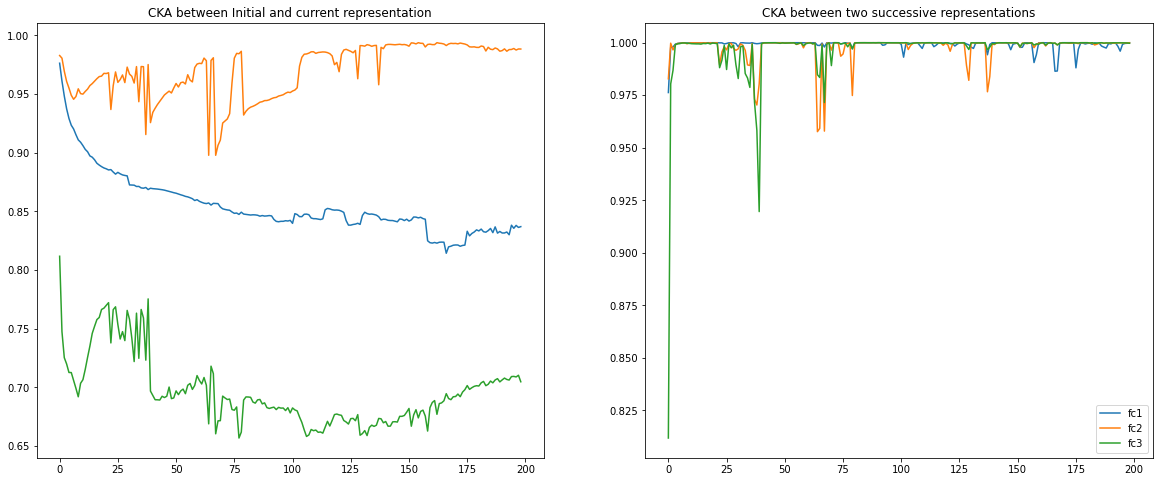

In [13]:
epochs_cka = [i for i in range(len(training.Liste_cka_init[0]))]

plt.figure(figsize = (20,8))
for layer in range(len(Names_hook)):
    plt.subplot(1,2,1)
    plt.plot(epochs_cka,training.Liste_cka_init[layer],label = Names_hook[layer])
    plt.title("CKA between Initial and current representation")
    plt.subplot(1,2,2)
    plt.title("CKA between two successive representations")
    plt.plot(epochs_cka,training.Liste_cka[layer],label = Names_hook[layer])

plt.legend()